# Data Structure and Dictionary

The Zee MovieLens dataset consists of three structured data files containing user ratings, demographic attributes, and movie metadata. These files collectively form the input for exploratory analysis and recommendation modeling.

---

### ratings.dat  
**Format:** `UserID::MovieID::Rating::Timestamp`

| Field | Description |
|------|-------------|
| UserID | Unique user identifier (range: 1–6040) |
| MovieID | Unique movie identifier (range: 1–3952) |
| Rating | Explicit whole-star rating on a 1–5 scale |
| Timestamp | Time of rating recorded in seconds |

Each user has provided a minimum of 20 ratings.

---

### users.dat  
**Format:** `UserID::Gender::Age::Occupation::Zip-code`

| Field | Description |
|------|-------------|
| UserID | Unique user identifier |
| Gender | Gender of the user (M/F) |
| Age | Age group bucket |
| Occupation | Encoded occupation category |
| Zip-code | User zip code |

Demographic information is self-reported and optional.

---

### movies.dat  
**Format:** `MovieID::Title::Genres`

| Field | Description |
|------|-------------|
| MovieID | Unique movie identifier |
| Title | Movie title including release year |
| Genres | Pipe-separated list of movie genres |

Genres include standard categories such as Action, Comedy, Drama, Romance, Sci-Fi, Thriller, and others.


# Installation, File Read and Imports

In [ ]:
PROJECT_ROOT = "/content/drive/MyDrive/Colab Notebooks/projects/Recommendation Systems"

In [ ]:
#!pip install cmfrec
#!pip install pgeocode

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from cmfrec import CMF
import pgeocode
import geopandas as gpd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Data Preprocessing and Feature Engineering

## User Dataset

In [ ]:
df_users = pd.read_csv(
    f"{PROJECT_ROOT}/zee-users.dat",
    sep="::",
    engine="python",
    header=None,
    encoding="latin-1"
)

df_users.head()

,0,1,2,3,4
0,UserID,Gender,Age,Occupation,Zip-code
1,1,F,1,10,48067
2,2,M,56,16,70072
3,3,M,25,15,55117
4,4,M,45,7,02460


The dataset is loaded using `sep="::"` to handle the custom delimiter, `engine="python"` to support this separator, `header=None` since the file has no proper header row, and `encoding="latin-1"` to correctly read special characters.

This dataset is not in the correct format initially, as the first row contains the column names; it needs to be set as headers for proper processing.

In [ ]:
df_users.columns = df_users.iloc[0]
df_users = df_users[1:]
df_users.reset_index(drop=True, inplace=True)
df_users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


The first row of the DataFrame, which contains the column names, is set as the header, and the index is reset to properly structure the table for further analysis.

In [ ]:
df_users.shape

(6040, 5)

The DataFrame contains 6040 users with 5 columns corresponding to `UserID`, `Gender`, `Age`, `Occupation`, and `Zip-code`.

In [ ]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   object
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   object
 3   Occupation  6040 non-null   object
 4   Zip-code    6040 non-null   object
dtypes: object(5)
memory usage: 236.1+ KB


 All 5 columns have 6040 non-null entries, with data types as objects, indicating that the dataset has no missing values but may require type conversion for numerical operations.

In [ ]:
df_users.describe()

,UserID,Gender,Age,Occupation,Zip-code
count,6040,6040,6040,6040,6040
unique,6040,2,7,21,3439
top,6040,M,25,4,48104
freq,1,4331,2096,759,19


The descriptive analysis shows that `UserID` values are all unique, `Gender` has 2 categories with 'M' as the most frequent, `Age` has 7 distinct groups with 25 being most common, `Occupation` spans 21 categories with 4 appearing most frequently, and `Zip-code` has 3439 unique values, with 48104 occurring most often.

The user data shows a gender imbalance toward males, dominance of certain age groups and occupations and object-type columns may need conversion for analysis.


In [ ]:
df_users['Age'] = pd.to_numeric(df_users['Age'], errors='coerce')
df_users['Occupation'] = df_users['Occupation'].astype('category')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   UserID      6040 non-null   object  
 1   Gender      6040 non-null   object  
 2   Age         6040 non-null   int64   
 3   Occupation  6040 non-null   category
 4   Zip-code    6040 non-null   object  
dtypes: category(1), int64(1), object(3)
memory usage: 195.5+ KB


The `Age` column has been converted from object to numeric type, and `Occupation` has been transformed into a categorical variable for further analysis.


## Movie Dataset

In [ ]:
df_movies = pd.read_csv(
    f"{PROJECT_ROOT}/zee-movies.dat",
    sep="::",
    engine="python",
    header=None,
    encoding="latin-1"
)

df_movies.head()


,0,1,2
0,Movie ID,Title,Genres
1,1,Toy Story (1995),Animation|Children's|Comedy
2,2,Jumanji (1995),Adventure|Children's|Fantasy
3,3,Grumpier Old Men (1995),Comedy|Romance
4,4,Waiting to Exhale (1995),Comedy|Drama


The dataset is structured similarly to the user dataset, with the first row containing column names; it requires the same preprocessing to set the first row as headers for proper analysis.


In [ ]:
df_movies.columns = df_movies.iloc[0]
df_movies = df_movies[1:]
df_movies.reset_index(drop=True, inplace=True)
df_movies.head()

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


The `Title` column contains both the movie name and release year, which can be separated into distinct fields, and the `Genres` column contains multiple genres concatenated by pipes (`|`), as a movie can belong to more than one genre.


In [ ]:
df_movies.shape

(3883, 3)

The DataFrame contains 3 columns (`Movie ID`, `Title`, `Genres`) and 3883 entries.


In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie ID  3883 non-null   object
 1   Title     3883 non-null   object
 2   Genres    3883 non-null   object
dtypes: object(3)
memory usage: 91.1+ KB


All three columns are non-null and stored as objects, indicating no missing data but requiring type conversion for numerical operations if needed.

In [ ]:
df_movies['Release_Year'] = df_movies['Title'].str.extract(r'\((\d{4})\)')
df_movies['Title'] = df_movies['Title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()
genres_dummies = df_movies['Genres'].str.get_dummies(sep='|')
df_movies = df_movies.drop('Genres', axis=1)
df_movies = pd.concat([df_movies, genres_dummies], axis=1)
df_movies.head()

,Movie ID,Title,Release_Year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


The `Title` column is processed to separate the release year from the movie name: the year is extracted into a new column `Release_Year`, and the title is cleaned by removing the year, resulting in a standardized movie name field.

The `Genres` column, originally containing multiple genres concatenated by pipes (`|`), is transformed into a set of **binary indicator (one-hot encoded) columns** representing the presence of each genre.

The original `Genres` column is removed, and the one-hot encoded genre columns are merged with the movie DataFrame.

This preprocessing creates a clean, analysis-ready dataset, structured to support exploratory analysis and to prepare the data for further processing and modeling.



In [ ]:
df_movies['Release_Year'] = pd.to_numeric(df_movies['Release_Year'], errors='coerce')

The `Release_Year` column has been converted from object to numeric type to facilitate further analysis.


In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Movie ID      3883 non-null   object
 1   Title         3883 non-null   object
 2   Release_Year  3883 non-null   int64 
 3   Action        3883 non-null   int64 
 4   Adventure     3883 non-null   int64 
 5   Animation     3883 non-null   int64 
 6   Children's    3883 non-null   int64 
 7   Comedy        3883 non-null   int64 
 8   Crime         3883 non-null   int64 
 9   Documentary   3883 non-null   int64 
 10  Drama         3883 non-null   int64 
 11  Fantasy       3883 non-null   int64 
 12  Film-Noir     3883 non-null   int64 
 13  Horror        3883 non-null   int64 
 14  Musical       3883 non-null   int64 
 15  Mystery       3883 non-null   int64 
 16  Romance       3883 non-null   int64 
 17  Sci-Fi        3883 non-null   int64 
 18  Thriller      3883 non-null   int64 
 19  War   

## Ratings Dataset

In [ ]:
df_ratings = pd.read_csv(
    f"{PROJECT_ROOT}/zee-ratings.dat",
    sep="::",
    engine="python",
    header=None,
    encoding="latin-1"
)

df_ratings.head()

,0,1,2,3
0,UserID,MovieID,Rating,Timestamp
1,1,1193,5,978300760
2,1,661,3,978302109
3,1,914,3,978301968
4,1,3408,4,978300275


The dataset is structured similarly to the user, movie dataset, with the first row containing column names; it requires the same preprocessing to set the first row as headers for proper analysis.


In [ ]:
df_ratings.columns = df_ratings.iloc[0]
df_ratings = df_ratings[1:]
df_ratings.reset_index(drop=True, inplace=True)
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


The dataset contains a `Timestamp` column in Unix format, representing the time at which each rating was recorded.


In [ ]:
print(df_ratings.shape)
print(df_ratings.info())

(1000209, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   UserID     1000209 non-null  object
 1   MovieID    1000209 non-null  object
 2   Rating     1000209 non-null  object
 3   Timestamp  1000209 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB
None


Dataset contains 1,000,210 entries across 4 columns, all stored as objects, with no missing values, indicating that type conversion is required for numerical operations and analysis here as well.

In [ ]:
df_ratings.describe()

,UserID,MovieID,Rating,Timestamp
count,1000209,1000209,1000209,1000209
unique,6040,3706,5,458455
top,4169,2858,4,975528402
freq,2314,3428,348971,30


The descriptive analysis of the ratings dataset shows that there are 6040 unique users and 3706 unique movies. Ratings are on a 1–5 scale, with 4 being the most frequent rating. The `Timestamp` column has 458,455 unique values, indicating multiple ratings recorded at the same time, and some users and movies appear more frequently, reflecting rating activity skewness.

In [ ]:
df_ratings['Rating'] = pd.to_numeric(df_ratings['Rating'], errors='coerce')
df_ratings['Timestamp'] = pd.to_numeric(df_ratings['Timestamp'], errors='coerce')

The `Rating` and `Timestamp` columns have been converted from object to numeric types to enable statistical analysis and exploratory data analysis.


In [ ]:
df_ratings_eda = df_ratings.copy()

df_ratings_eda['Timestamp'] = pd.to_datetime(df_ratings_eda['Timestamp'], unit='s')
df_ratings_eda['year'] = df_ratings_eda['Timestamp'].dt.year
df_ratings_eda['month'] = df_ratings_eda['Timestamp'].dt.month
df_ratings_eda['dayofweek'] = df_ratings_eda['Timestamp'].dt.dayofweek
df_ratings_eda['hour'] = df_ratings_eda['Timestamp'].dt.hour

user_stats = df_ratings_eda.groupby('UserID')['Rating'].agg(
    user_mean_rating='mean',
    user_rating_count='count'
).reset_index()
df_ratings_eda = df_ratings_eda.merge(user_stats, on='UserID', how='left')

movie_stats = df_ratings_eda.groupby('MovieID')['Rating'].agg(
    movie_mean_rating='mean',
    movie_rating_count='count'
).reset_index()
df_ratings_eda = df_ratings_eda.merge(movie_stats, on='MovieID', how='left')

df_ratings_eda.head()

,UserID,MovieID,Rating,Timestamp,year,month,dayofweek,hour,user_mean_rating,user_rating_count,movie_mean_rating,movie_rating_count
0,1,1193,5,2000-12-31 22:12:40,2000,12,6,22,4.188679,53,4.390725,1725
1,1,661,3,2000-12-31 22:35:09,2000,12,6,22,4.188679,53,3.464762,525
2,1,914,3,2000-12-31 22:32:48,2000,12,6,22,4.188679,53,4.154088,636
3,1,3408,4,2000-12-31 22:04:35,2000,12,6,22,4.188679,53,3.863878,1315
4,1,2355,5,2001-01-06 23:38:11,2001,1,5,23,4.188679,53,3.854375,1703


A copy of the ratings DataFrame is created (`df_ratings_eda`) to preserve the original data for model training.

The `Timestamp` column is converted to datetime format, from which new temporal features are extracted: `year`, `month`, `dayofweek`and `hour`

Additionally, user-level statistics (`user_mean_rating`, `user_rating_count`) and movie-level statistics (`movie_mean_rating`, `movie_rating_count`) are computed and merged back into the DataFrame.

These engineered features facilitate detailed exploratory analysis of rating patterns by time, user activity, and movie popularity.

**Features created**

- **year**: Year when the rating was recorded  
- **month**: Month of the rating  
- **dayofweek**: Day of the week of the rating (0=Monday, 6=Sunday)  
- **hour**: Hour of the day when the rating was made  
- **user_mean_rating**: Average rating given by the user  
- **user_rating_count**: Total number of ratings made by the user  
- **movie_mean_rating**: Average rating received by the movie  
- **movie_rating_count**: Total number of ratings received by the movie


In [ ]:
print(df_ratings_eda.shape)
print(df_ratings_eda.info())
print(df_ratings_eda.describe())

(1000209, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   UserID              1000209 non-null  object        
 1   MovieID             1000209 non-null  object        
 2   Rating              1000209 non-null  int64         
 3   Timestamp           1000209 non-null  datetime64[ns]
 4   year                1000209 non-null  int32         
 5   month               1000209 non-null  int32         
 6   dayofweek           1000209 non-null  int32         
 7   hour                1000209 non-null  int32         
 8   user_mean_rating    1000209 non-null  float64       
 9   user_rating_count   1000209 non-null  int64         
 10  movie_mean_rating   1000209 non-null  float64       
 11  movie_rating_count  1000209 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(3), ob

The EDA descriptive statistics for the processed ratings DataFrame reveal the following insights:

- **Rating values** range from 1 to 5, with a mean around 3.58, indicating a slight positive bias in user ratings.  
- **Timestamps** span from April 2000 to February 2003, with ratings distributed across all months, days of the week, and hours, and about 25% of ratings occurring on weekends.  
- **User activity** shows that individual users have rated between 20 and 2,314 movies, with a median of 302 ratings per user.  
- **Movie popularity** varies widely, with each movie receiving between 1 and 3,428 ratings, median of 645, and mean around 816.  
- **User and movie average ratings** are tightly clustered around 3.5–3.6, with standard deviations indicating moderate variability.  

These statistics provide a comprehensive overview of rating behavior, temporal patterns, and the distribution of user and movie activity, which are useful for guiding further exploratory analysis and model development.

The data types are correctly identified, with `Timestamp` converted to datetime, `Rating` to numeric, and derived features like `year`, `month`, `dayofweek`, and `hour` as integers, ensuring proper handling for temporal analysis and statistical computations.


# EDA

##Dataset Overview
Preprocessing and feature engineering provide a clear overview of the movie-rating ecosystem:  

- **Users:** 6,040  
- **Movies:** 3,883  
- **Ratings:** 1,000,209  
- **Rating time span:** April 2000 to February 2003  

This highlights the dataset's scale and reliability, providing context for exploratory analysis and recommendation model development.


## Demograpic Profile Analysis

This section examines the characteristics of users by analyzing:

- **Age distribution** – understanding the spread of users across different age groups  
- **Gender distribution** – identifying the proportion of male and female users  
- **Occupation distribution** – exploring the variety and frequency of user occupations  
- **Geographic distribution** – mapping users by zip-code to understand regional patterns and concentrations


In [ ]:
age_map = {
    1: "Under 18",
    18: "18-24",
    25: "25-34",
    35: "35-44",
    45: "45-49",
    50: "50-55",
    56: "56+"
}
df_users['Age'] = df_users['Age'].map(age_map)
df_users['Occupation'] = pd.to_numeric(df_users['Occupation'], errors='coerce')
occupation_map = {
    0: "other",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}

df_users['Occupation'] = df_users['Occupation'].map(occupation_map)
df_users['Occupation'] = df_users['Occupation'].astype('category')

Age and Occupation mappings are created to replace numeric codes with meaningful labels, facilitating clearer visualization and interpretation of user demographics.


/tmp/ipython-input-2633177638.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=df_users, ax=axes[0,1], palette={'M':'dodgerblue','F':'lightpink'})


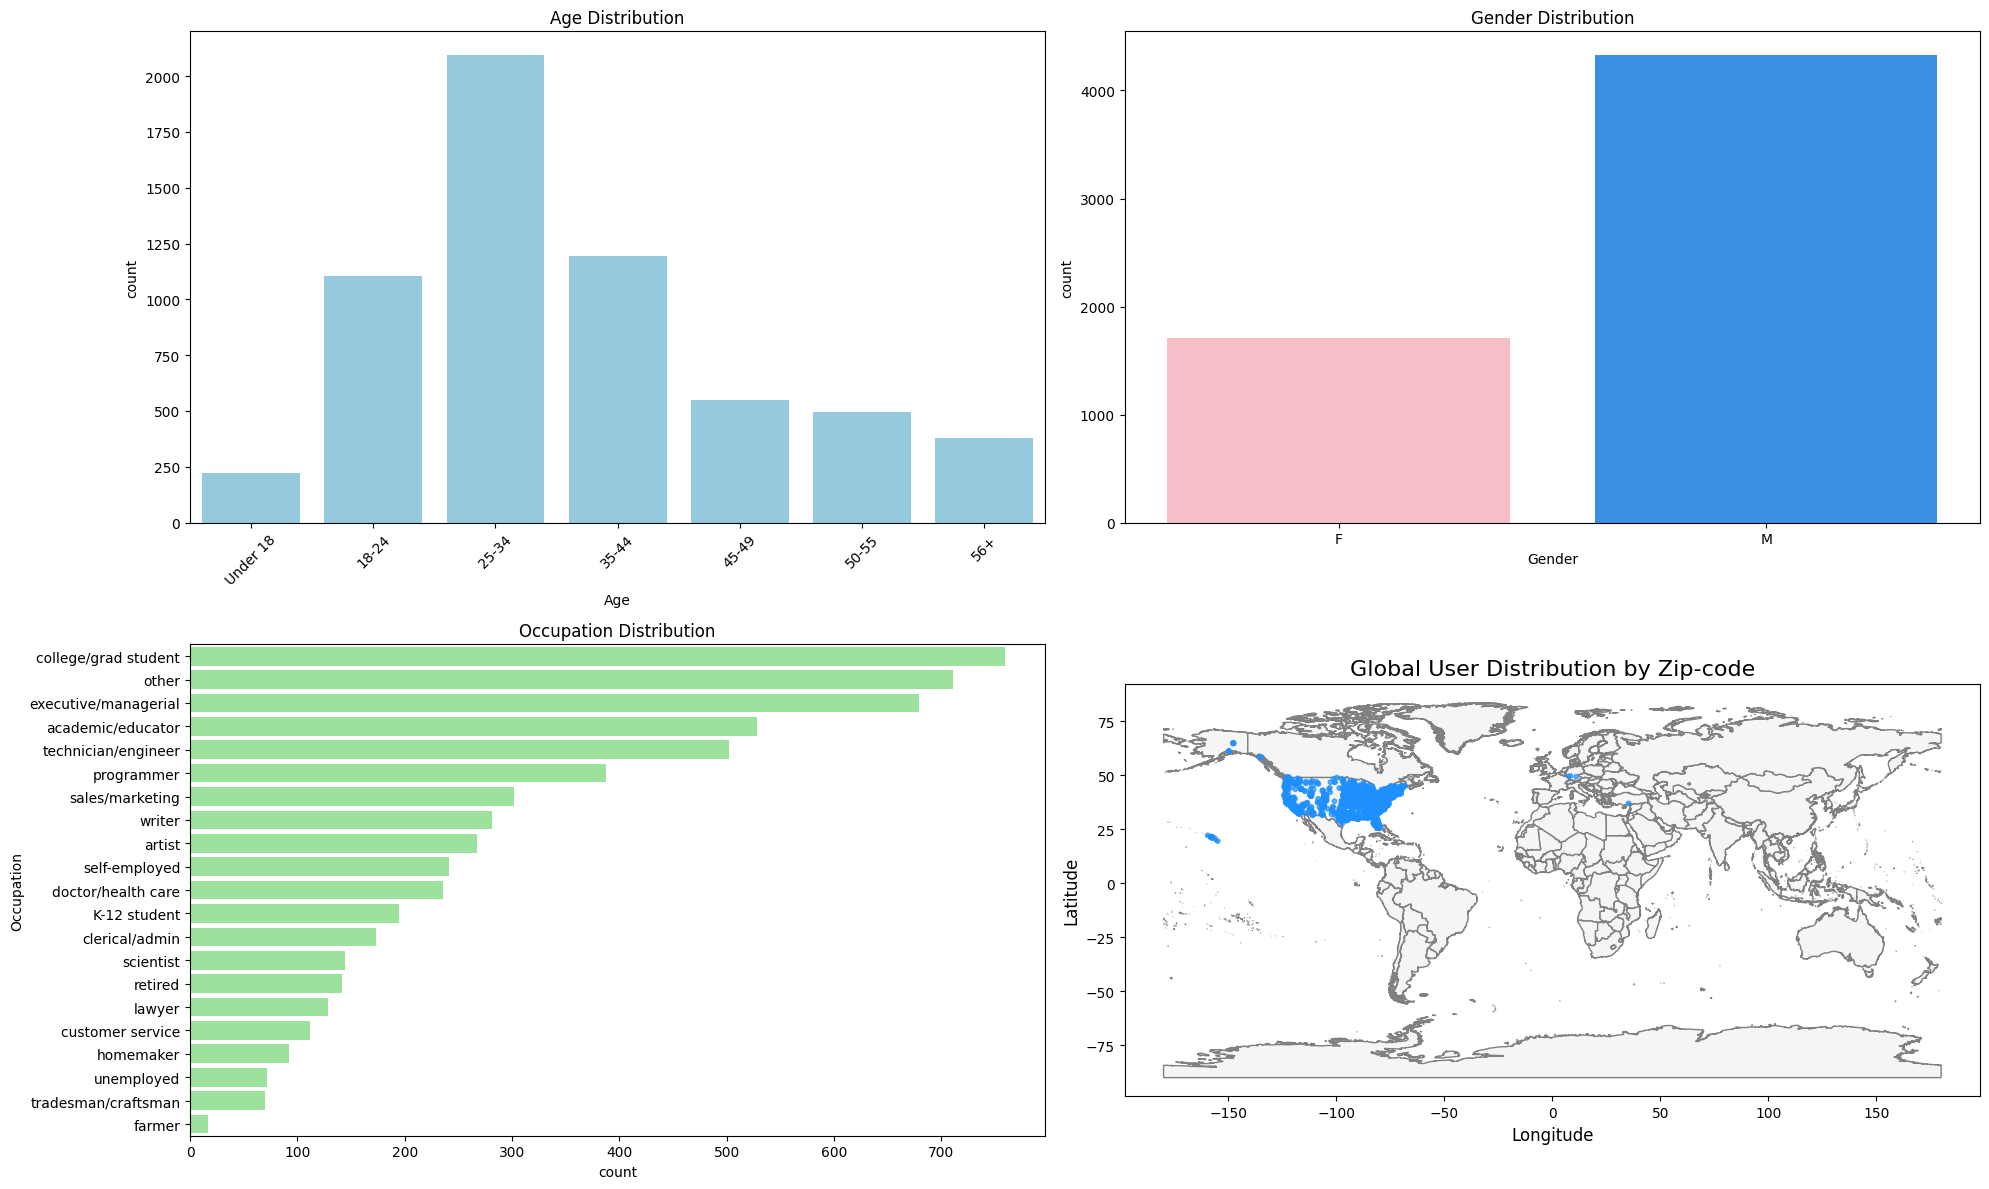

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

sns.countplot(x='Age', data=df_users, order=[
    "Under 18", "18-24", "25-34", "35-44", "45-49", "50-55", "56+"],
    ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Age Distribution')
axes[0,0].tick_params(axis='x', rotation=45)

sns.countplot(x='Gender', data=df_users, ax=axes[0,1], palette={'M':'dodgerblue','F':'lightpink'})
axes[0,1].set_title('Gender Distribution')

sns.countplot(y='Occupation', data=df_users.dropna(subset=['Occupation']),
    order=df_users['Occupation'].value_counts().index, ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Occupation Distribution')

nomi = pgeocode.Nominatim('us')
coords = nomi.query_postal_code(df_users['Zip-code'].unique())[["postal_code","latitude","longitude"]]
coords.rename(columns={'postal_code':'Zip-code'}, inplace=True)
df_map = df_users.merge(coords, on='Zip-code', how='left').groupby(
    ['Zip-code','latitude','longitude']).size().reset_index(name='user_count')
df_map = df_map.dropna(subset=['latitude','longitude'])
world = gpd.read_file("https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson")
gdf = gpd.GeoDataFrame(df_map, geometry=gpd.points_from_xy(df_map.longitude, df_map.latitude))
world.plot(ax=axes[1,1], color='whitesmoke', edgecolor='gray')
gdf.plot(ax=axes[1,1], markersize=(gdf['user_count']**0.5)*10, color='dodgerblue', alpha=0.7)
axes[1,1].set_title("Global User Distribution by Zip-code", fontsize=16)
axes[1,1].set_xlabel("Longitude", fontsize=12)
axes[1,1].set_ylabel("Latitude", fontsize=12)

plt.tight_layout()
plt.show()

The purpose of this analysis is to understand who the users are. Graphical exploration of the data shows patterns that align closely with the descriptive statistics:  

- **Age distribution:** The majority of users are aged 25–34, followed by 35–44, confirming that the core user base is centered around the 18–44 age range.  
- **Gender distribution:** Males significantly outnumber females, consistent with descriptive insights, possibly due to household registration patterns or account-sharing behavior.  
- **Occupation distribution:** College/graduate students are the largest group, followed by executive/managerial roles, academic/educators, and technical professions, indicating a young, educated, and professional user base.  
- **Geographic distribution:** Most users are located in the United States, concentrated along the East and West coasts, fewer in central regions, and very few from Europe or Hawaii, reflecting platform accessibility and popularity.  

Overall, the graphical analysis corroborates the descriptive findings and provides a clear understanding of the user demographics that drive engagement on the platform.


## Movie Content Analysis

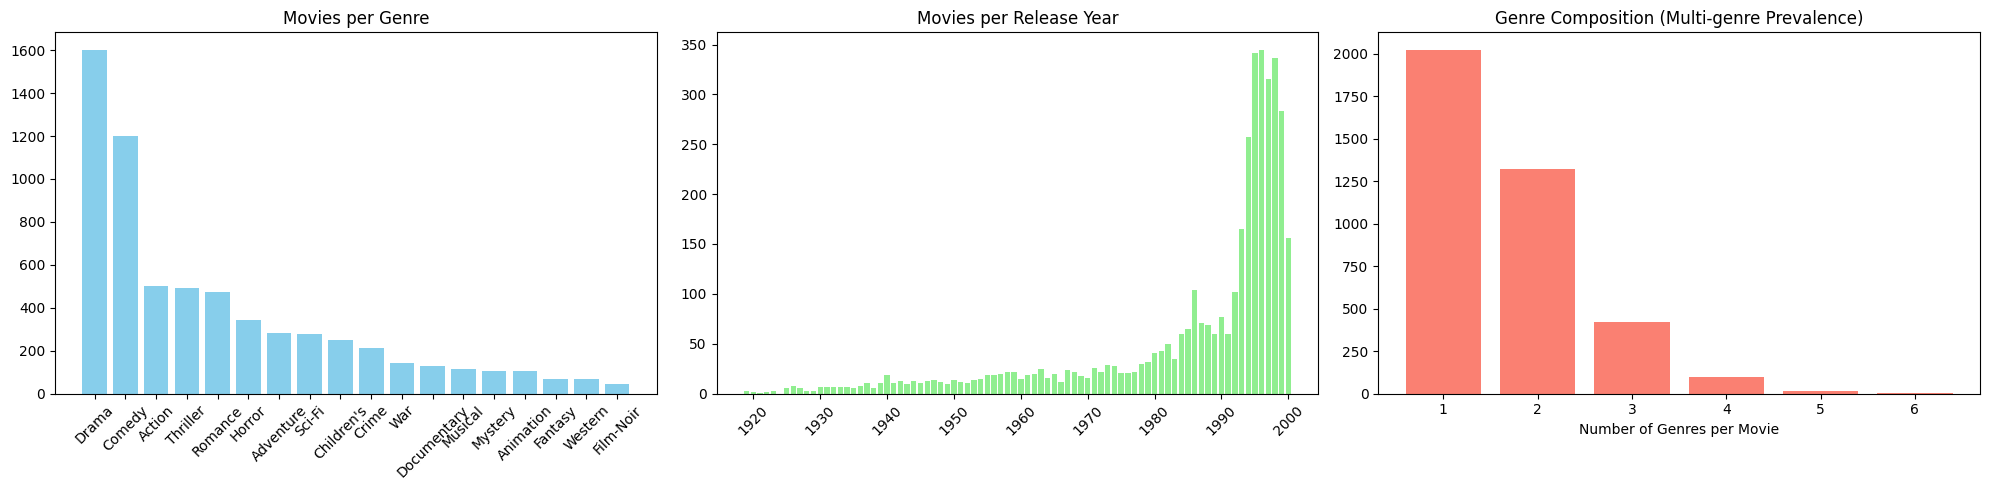

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

genre_cols = df_movies.columns[3:]
genre_counts = df_movies[genre_cols].sum().sort_values(ascending=False)
axes[0].bar(genre_counts.index, genre_counts.values, color='skyblue')
axes[0].set_title('Movies per Genre')
axes[0].tick_params(axis='x', rotation=45)

release_counts = df_movies['Release_Year'].value_counts().sort_index()
axes[1].bar(release_counts.index, release_counts.values, color='lightgreen')
axes[1].set_title('Movies per Release Year')
axes[1].tick_params(axis='x', rotation=45)

df_movies['genre_count'] = df_movies[genre_cols].sum(axis=1)
composition_counts = df_movies['genre_count'].value_counts().sort_index()
axes[2].bar(composition_counts.index, composition_counts.values, color='salmon')
axes[2].set_title('Genre Composition (Multi-genre Prevalence)')
axes[2].set_xlabel('Number of Genres per Movie')

plt.tight_layout()
plt.show()


The purpose of this analysis is to understand what types of movies are available for recommendation.  

- **Movies per genre:** Most movies are in Drama (≈1,600) and Comedy (≈1,200), with fewer than 450 in other genres. Animation, Fantasy, Western, and Film-Noir are underrepresented.  
- **Release trends:** Movie releases start gradually from the 1920s, with small peaks in the 1980s and a large surge in the 1990s, reflecting industry growth and better data coverage.  
- **Genre composition:** The majority of movies are single-genre, followed by films with 2 or 3 genres, and a few movies span 5–6 genres, showing occasional genre blending.  

This analysis provides insight into the distribution and characteristics of movies that the recommendation system will suggest, helping contextualize user preferences and recommendation patterns.

## Rating Activity Analysis (Users & Movies)

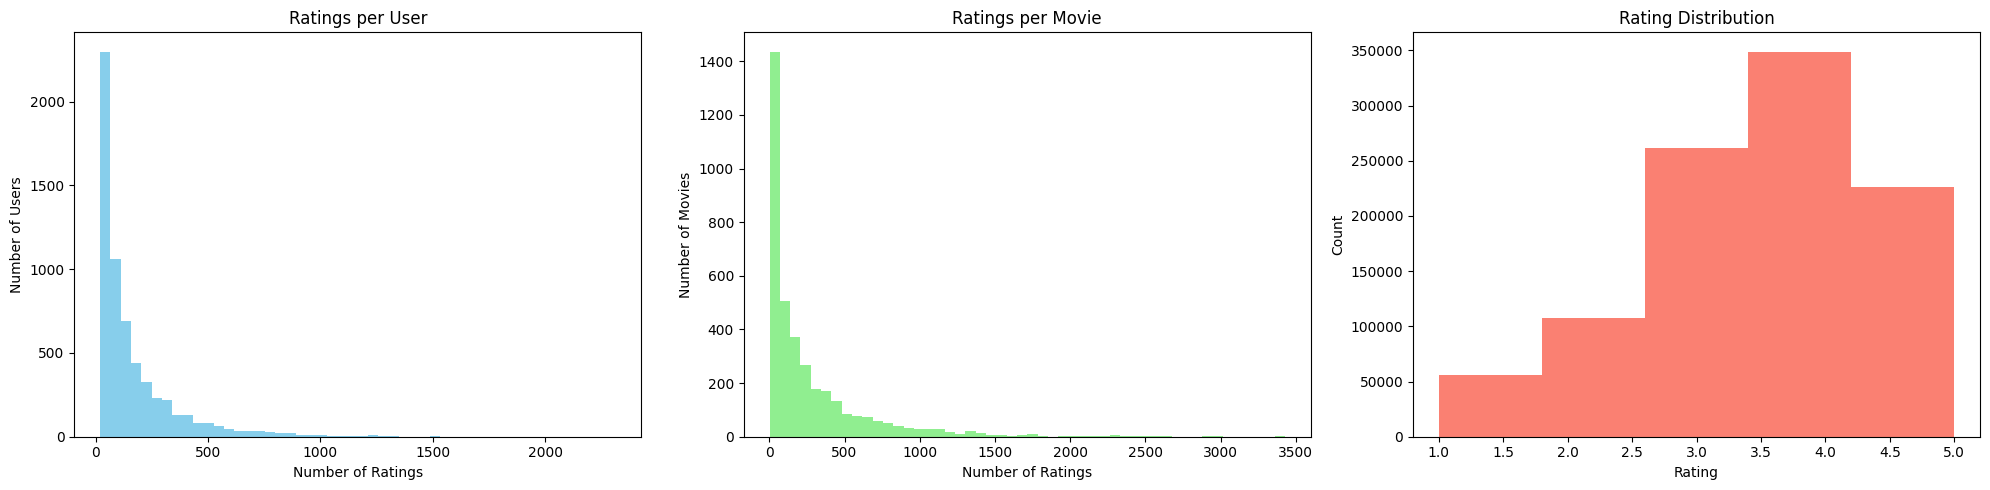

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

ratings_per_user = df_ratings.groupby('UserID')['Rating'].count()
axes[0].hist(ratings_per_user, bins=50, color='skyblue')
axes[0].set_title('Ratings per User')
axes[0].set_xlabel('Number of Ratings')
axes[0].set_ylabel('Number of Users')

ratings_per_movie = df_ratings.groupby('MovieID')['Rating'].count()
axes[1].hist(ratings_per_movie, bins=50, color='lightgreen')
axes[1].set_title('Ratings per Movie')
axes[1].set_xlabel('Number of Ratings')
axes[1].set_ylabel('Number of Movies')

axes[2].hist(df_ratings['Rating'], bins=5, color='salmon')
axes[2].set_title('Rating Distribution')
axes[2].set_xlabel('Rating')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()


This analysis focuses on understanding engagement intensity:  

- **Ratings per user:** Highlights the number of movies rated by each user, revealing highly active "power users."  
- **Ratings per movie:** Shows the number of ratings received by each movie, identifying popular or widely viewed items.  
- **Average rating distribution:** Confirms a positive bias in ratings and indicates that most users provide multiple ratings, reducing the risk of cold-start issues.  

Overall, this analysis provides insights into user activity patterns and item popularity, which are critical for shaping collaborative filtering and recommendation strategies.


## Genre Preference Analysis

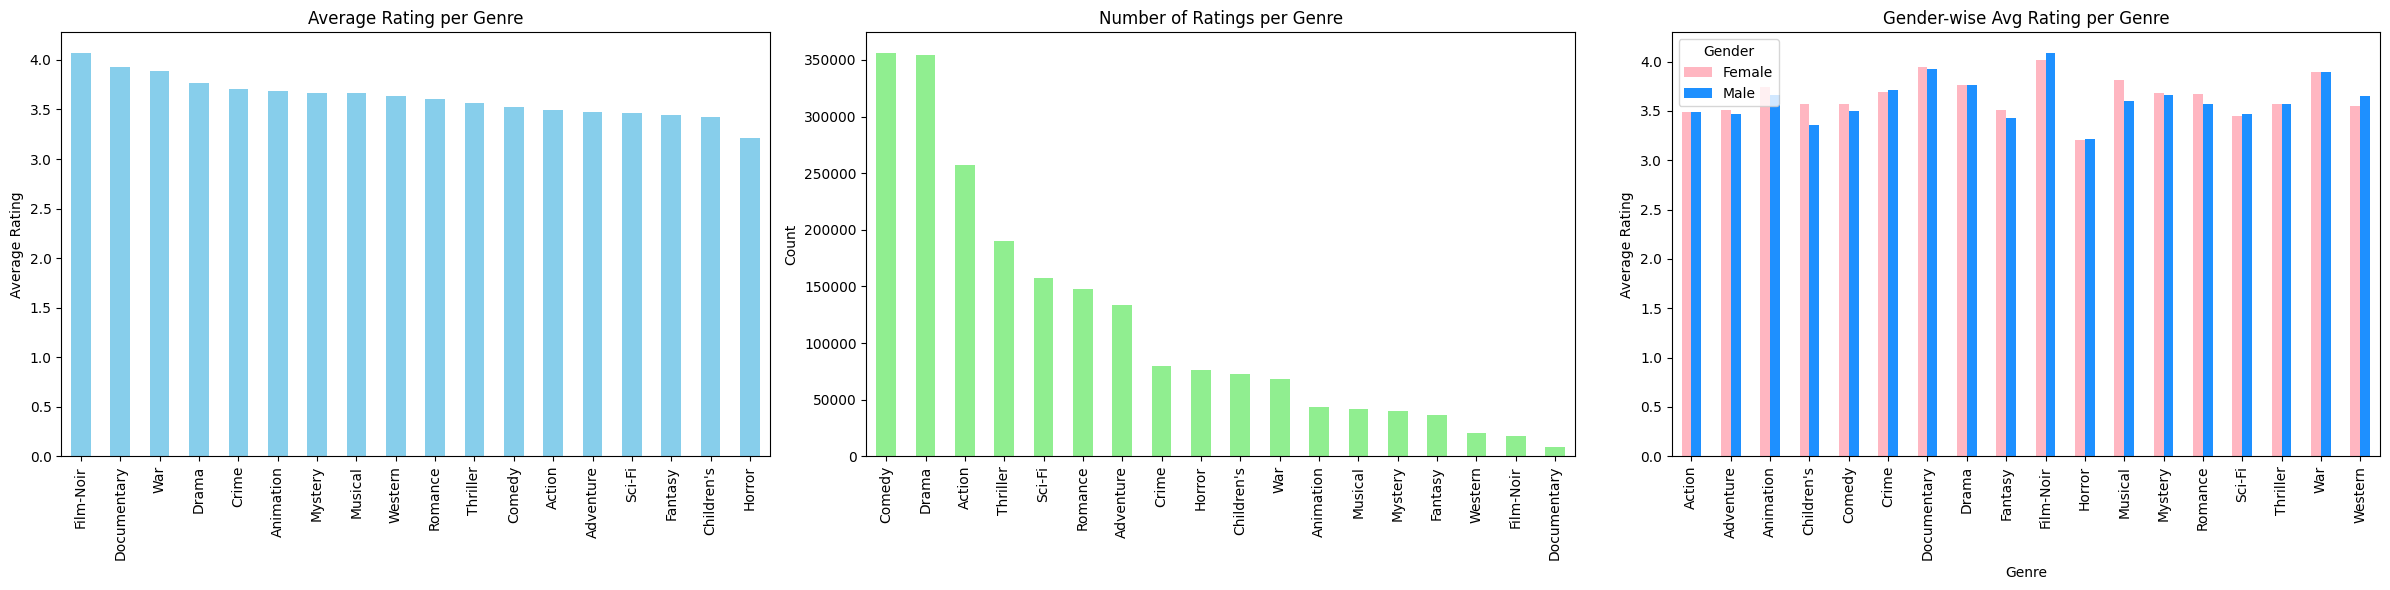

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

genre_cols = [c for c in df_movies.columns[3:] if c != 'genre_count']

df_ratings_movies = df_ratings.merge(
    df_movies[['Movie ID'] + list(genre_cols)],
    left_on='MovieID', right_on='Movie ID', how='left'
).drop(columns=['Movie ID'])

df_gender = df_ratings_movies.merge(df_users[['UserID','Gender']], on='UserID', how='left')

avg_rating_genre = pd.Series({
    g: df_ratings_movies[df_ratings_movies[g]==1]['Rating'].mean()
    for g in genre_cols
}).sort_values(ascending=False)

count_rating_genre = pd.Series({
    g: df_ratings_movies[df_ratings_movies[g]==1]['Rating'].count()
    for g in genre_cols
}).sort_values(ascending=False)

gender_genre = df_gender.melt(
    id_vars=['UserID','Gender','Rating'],
    value_vars=genre_cols,
    var_name='Genre', value_name='is_genre'
)
gender_genre = gender_genre[gender_genre['is_genre']==1]
gender_genre = gender_genre.groupby(['Genre','Gender'])['Rating'].mean().unstack()
gender_genre = gender_genre.astype(float)

avg_rating_genre.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Average Rating per Genre')
axes[0].set_ylabel('Average Rating')

count_rating_genre.plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Number of Ratings per Genre')
axes[1].set_ylabel('Count')

gender_genre.plot(kind='bar', ax=axes[2], color=['lightpink','dodgerblue'])
axes[2].set_title('Gender-wise Avg Rating per Genre')
axes[2].set_ylabel('Average Rating')
axes[2].legend(title='Gender', labels=['Female','Male'])

plt.tight_layout()
plt.show()


This analysis links user behavior with movie content to inform recommendation strategies:  

- **Average rating per genre:** Highest in Film-Noir, Documentary, and War; lowest in Horror. Popular genres like Comedy, Drama, and Action have moderate ratings, showing the **"Quality vs. Popularity" paradox**.  
- **Genre popularity vs. quality:** Niche genres receive fewer ratings but higher scores; mass-appeal genres are widely rated with average scores.  
- **Gender alignment:** Men and women have similar rating patterns; small differences appear in Musicals, Romance, Film-Noir, and Westerns. Horror is low-rated across both genders.  
- **Rating volume:** Males provide ~3x more ratings than females; female ratings are slightly higher on average.  

Insights help bridge content and user behavior for content-aware or hybrid recommendation approaches.


## Release Year Popularity and Biases

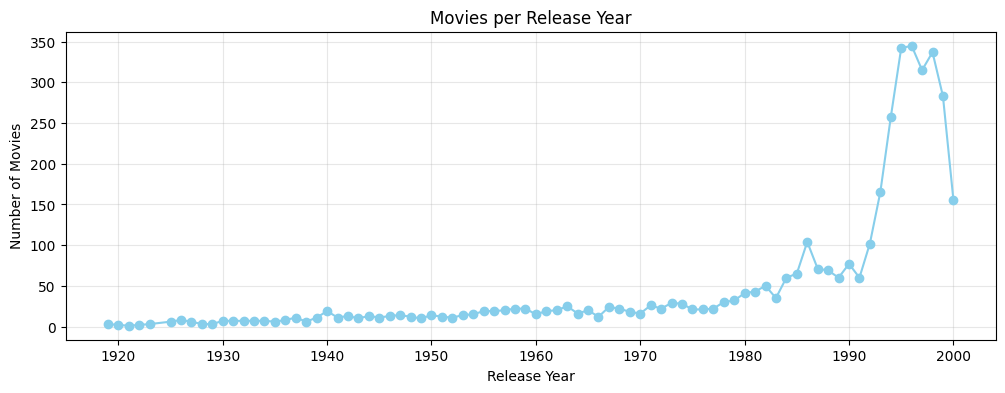

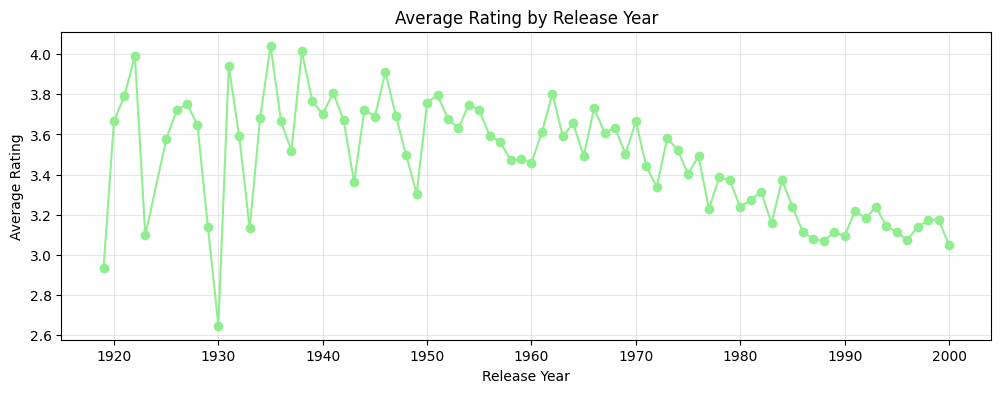

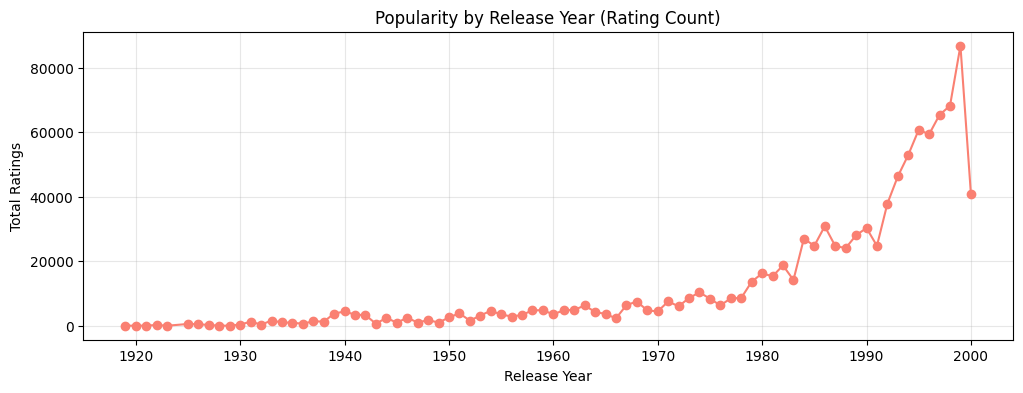

In [ ]:
df_movies_stats = df_movies.merge(
    df_ratings_eda.groupby('MovieID')[['movie_rating_count','movie_mean_rating']].first().reset_index(),
    left_on='Movie ID', right_on='MovieID', how='left'
)

movies_per_year = df_movies.groupby('Release_Year')['Title'].count()
avg_rating_year = df_movies_stats.groupby('Release_Year')['movie_mean_rating'].mean()
popularity_year = df_movies_stats.groupby('Release_Year')['movie_rating_count'].sum()

plt.figure(figsize=(12,4))
plt.plot(movies_per_year.index, movies_per_year.values, marker='o', color='skyblue')
plt.title('Movies per Release Year')
plt.ylabel('Number of Movies')
plt.xlabel('Release Year')
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(avg_rating_year.index, avg_rating_year.values, marker='o', color='lightgreen')
plt.title('Average Rating by Release Year')
plt.ylabel('Average Rating')
plt.xlabel('Release Year')
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(popularity_year.index, popularity_year.values, marker='o', color='salmon')
plt.title('Popularity by Release Year (Rating Count)')
plt.ylabel('Total Ratings')
plt.xlabel('Release Year')
plt.grid(alpha=0.3)
plt.show()


This analysis examines temporal patterns in movie production, popularity, and ratings from 1920 to 2000:

- **Movies per year:** Low and stable until the late 1970s; spikes in the 1990s, peaking around 1995–1998.  
- **Popularity (ratings count):** Follows production trends; late 90s movies receive the most ratings, showing recency bias.  
- **Average rating:** Higher for older movies (1920–1960, 3.6–4.0) and declines toward 2000 (~3.0–3.2), indicating survivorship bias.  

Older movies are fewer but highly rated; modern movies are more numerous and popular but average ratings are moderate.


## User Rating Behavior Over Time

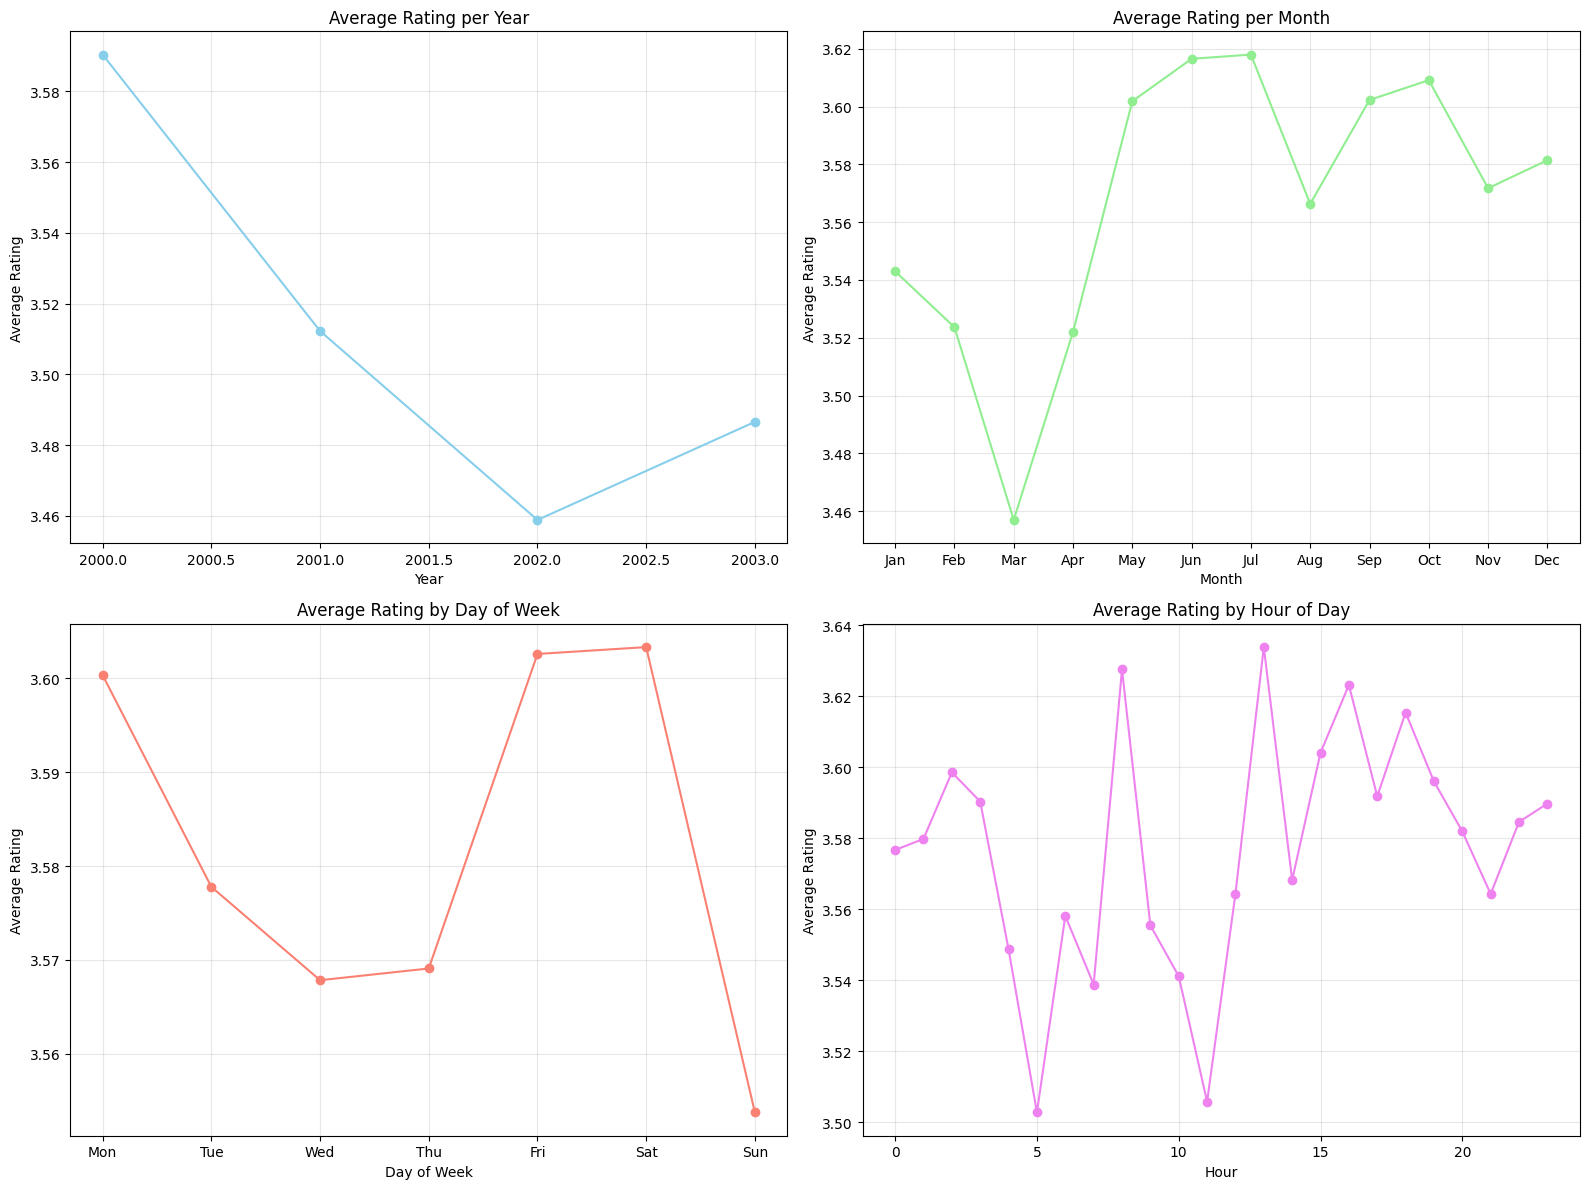

In [ ]:
import calendar

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

yearly_ratings = df_ratings_eda.groupby('year')['Rating'].mean()
monthly_ratings = df_ratings_eda.groupby('month')['Rating'].mean()
weekday_ratings = df_ratings_eda.groupby('dayofweek')['Rating'].mean()
hourly_ratings = df_ratings_eda.groupby('hour')['Rating'].mean()

axes[0,0].plot(yearly_ratings.index.astype(int), yearly_ratings.values, marker='o', color='skyblue')
axes[0,0].set_title('Average Rating per Year')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Average Rating')
axes[0,0].grid(alpha=0.3)

axes[0,1].plot(monthly_ratings.index, monthly_ratings.values, marker='o', color='lightgreen')
axes[0,1].set_xticks(range(1,13))
axes[0,1].set_xticklabels([calendar.month_abbr[m] for m in range(1,13)])
axes[0,1].set_title('Average Rating per Month')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Average Rating')
axes[0,1].grid(alpha=0.3)

axes[1,0].plot(weekday_ratings.index, weekday_ratings.values, marker='o', color='salmon')
axes[1,0].set_xticks(range(7))
axes[1,0].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
axes[1,0].set_title('Average Rating by Day of Week')
axes[1,0].set_xlabel('Day of Week')
axes[1,0].set_ylabel('Average Rating')
axes[1,0].grid(alpha=0.3)

axes[1,1].plot(hourly_ratings.index, hourly_ratings.values, marker='o', color='violet')
axes[1,1].set_title('Average Rating by Hour of Day')
axes[1,1].set_xlabel('Hour')
axes[1,1].set_ylabel('Average Rating')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


This analysis explores when users interact with the platform across yearly, monthly, weekly, and hourly scales.

**Yearly Trends:**  
- Massive increase in movie ratings from the early 1990s, peaking 1995–1998.  
- Older movies (1920–1950s) have higher average ratings (~3.6–4.0) than late 90s (~3.0–3.2), showing survivorship bias as confirmed from previous plots of release date as well.  

**Monthly Trends:**  
- Rating activity peaks during December/January and June/July, aligning with holidays and blockbuster releases.  
- Average rating remains fairly consistent across months (~3.5).  

**Weekly Trends:**  
- Higher activity on weekends (Fri–Sun); mid-week (Tue–Wed) sees the lowest engagement.  

**Hourly Trends:**  
- Peak activity in the evening (8 PM–12 AM), reflecting post-movie rating behavior.  
- Low activity in early morning (4 AM–8 AM); minor midday bump around lunch.  

User engagement is strongly influenced by leisure time, holidays, and recency of content, providing behavioral depth for recommendation modeling.


## Popularity Trend

/tmp/ipython-input-2048023313.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_avg = df_ratings_eda.groupby('MovieID').apply(lambda x: x['Rating'].mean() if x['movie_rating_count'].iloc[0]>=50 else np.nan)


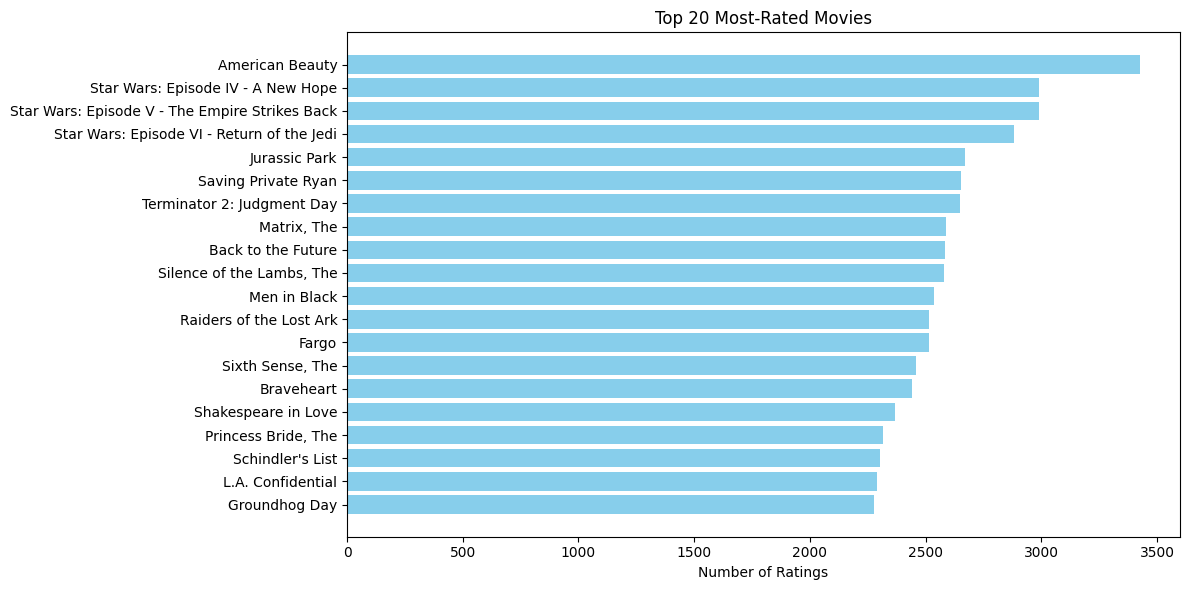

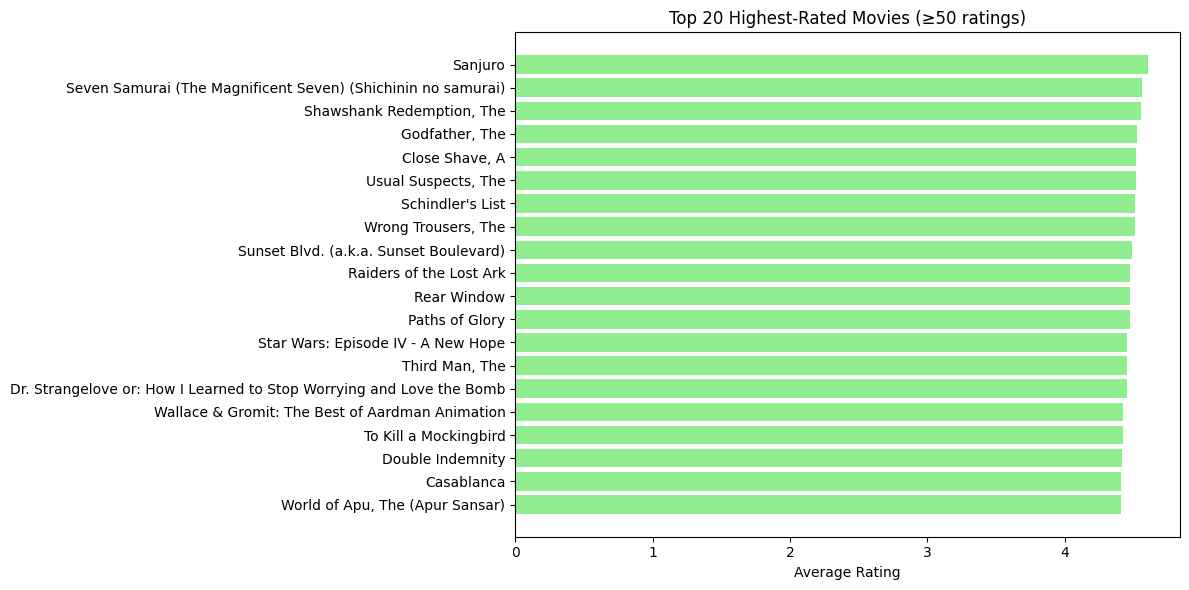

In [ ]:
top_count = df_ratings_eda.groupby('MovieID')['movie_rating_count'].first()
top_avg = df_ratings_eda.groupby('MovieID').apply(lambda x: x['Rating'].mean() if x['movie_rating_count'].iloc[0]>=50 else np.nan)

top_count = top_count.sort_values(ascending=False).head(20)
top_avg = top_avg.dropna().sort_values(ascending=False).head(20)

titles_count = df_movies.set_index('Movie ID').loc[top_count.index, 'Title']
titles_avg   = df_movies.set_index('Movie ID').loc[top_avg.index, 'Title']

plt.figure(figsize=(12,6))
plt.barh(titles_count[::-1], top_count.values[::-1], color='skyblue')
plt.title('Top 20 Most-Rated Movies')
plt.xlabel('Number of Ratings')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
plt.barh(titles_avg[::-1], top_avg.values[::-1], color='lightgreen')
plt.title('Top 20 Highest-Rated Movies (≥50 ratings)')
plt.xlabel('Average Rating')
plt.tight_layout()
plt.show()


This analysis tries to understand film engagement and viewer appreciation by comparing most-watched versus highest-rated movies.  

1. **Most-Rated Movies (Top 20)**  
   - Represents engagement volume; dominated by 1990s blockbusters.  
   - *American Beauty* leads with nearly 3,500 ratings.  
   - Original *Star Wars* trilogy occupies three of the top four spots.  
   - Genre variety includes sci-fi, action, drama, and comedy.  
   - Reflects the "90s Boom" in production and audience attention.

2. **Highest-Rated Movies (Top 20, ≥50 ratings)**  
   - Focuses on quality while controlling for low-sample bias.  
   - *Sanjuro* and *Seven Samurai* are at the top.  
   - Includes international and classic films like *Casablanca* and *The World of Apu*.  
   - Perennial favorites (*The Shawshank Redemption*, *The Godfather*) are highly rated despite fewer ratings.  

3.   Only a few films achieve both high popularity and high ratings: *Star Wars: Episode IV*, *Schindler’s List*, *Raiders of the Lost Ark*.  


- Most-watched movies are generally recent blockbusters, driven by production volume and accessibility.  
- Highest-rated films tend to be older classics, suggesting enduring appeal and critical acclaim.  
- Popularity and quality do not always align, highlighting a distinction between engagement and viewer satisfaction.


## Sparsity Analysis

In [ ]:
num_users = df_ratings_eda['UserID'].nunique()
num_items = df_ratings_eda['MovieID'].nunique()
num_ratings = len(df_ratings_eda)

sparsity = 1 - (num_ratings / (num_users * num_items))
print(f"Number of users: {num_users}")
print(f"Number of items: {num_items}")
print(f"Number of ratings: {num_ratings}")
print(f"User-Item Sparsity: {sparsity:.6f}")

Number of users: 6040
Number of items: 3706
Number of ratings: 1000209
User-Item Sparsity: 0.955316


The user–item matrix is highly sparse (≈95%), which makes traditional collaborative filtering challenging.

Initially, user–user and item–item similarities are computed using Pearson and Cosine metrics to assess whether memory-based collaborative filtering can capture meaningful patterns. Due to high sparsity, these methods are expected to underperform.

Subsequently, matrix factorization is applied to uncover latent user–movie interactions, with prediction accuracy evaluated using MAPE.

Finally, a neural network model is explored to capture more complex relationships and its performance is compared to matrix factorization to assess improvements over baseline similarity-based approaches.